# DA5401 A7 — Multi-Class Model Selection using ROC and Precision-Recall Curves


In [15]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Data loading and preparation

This dataset is provided as `sat.trn` and `sat.tst`. The last column is the class label. We will discard samples belonging to the 'all types present' class if present (commonly label 7). 

In [16]:
df_train = pd.read_csv("sat.trn", delim_whitespace=True, header=None)
df_test = pd.read_csv("sat.tst", delim_whitespace=True, header=None)

df = pd.concat([df_train, df_test], ignore_index=True)


/tmp/ipykernel_3903/659666713.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_train = pd.read_csv("sat.trn", delim_whitespace=True, header=None)
/tmp/ipykernel_3903/659666713.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_test = pd.read_csv("sat.tst", delim_whitespace=True, header=None)


In [17]:
df.shape

(6435, 37)

In [18]:
df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3


In [19]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].astype(int).values

In [20]:
np.unique(y)

array([1, 2, 3, 4, 5, 7])

In [21]:
mask = y != 7
X, y = X[mask], y[mask]

In [22]:
X.shape

(4927, 36)

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, stratify=y, random_state=42)

In [25]:
classes = np.unique(y_train)
n_classes = len(classes)
n_classes

5

## Part A: Train baseline models

We will train: KNN, Decision Tree, Dummy (prior), Logistic Regression, GaussianNB, and SVC (with probability=True). We'll collect predictions and prediction probabilities for each model for later ROC/PRC analyses.

In [26]:
y_proba = {}   # for predicted probabilities
y_pred = {}    # for predicted classes

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

y_pred["KNN"] = y_pred_knn
y_proba["KNN"] = y_proba_knn

print(f"KNN → Accuracy: {acc_knn:.4f}, Weighted F1: {f1_knn:.4f}")

KNN → Accuracy: 0.9359, Weighted F1: 0.9353


In [28]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)

acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

y_pred["DT"] = y_pred_dt
y_proba["DT"] = y_proba_dt

print(f"Decision Tree → Accuracy: {acc_dt:.4f}, Weighted F1: {f1_dt:.4f}")


Decision Tree → Accuracy: 0.8994, Weighted F1: 0.8988


In [29]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='prior', random_state=0)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)

acc_dummy = accuracy_score(y_test, y_pred_dummy)
f1_dummy = f1_score(y_test, y_pred_dummy, average='weighted')

y_pred["DUMMY"] = y_pred_dummy
y_proba["DUMMY"] = y_proba_dummy

print(f"Dummy (Prior) → Accuracy: {acc_dummy:.4f}, Weighted F1: {f1_dummy:.4f}")

Dummy (Prior) → Accuracy: 0.3109, Weighted F1: 0.1474


In [30]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear')
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
y_proba_log = logreg.predict_proba(X_test)

acc_log = accuracy_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log, average='weighted')

y_pred["LOG"] = y_pred_log
y_proba["LOG"] = y_proba_log

print(f"Logistic Regression → Accuracy: {acc_log:.4f}, Weighted F1: {f1_log:.4f}")

Logistic Regression → Accuracy: 0.8904, Weighted F1: 0.8850


/home/swara/jupyter_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/swara/jupyter_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


In [31]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
y_proba_nb = nb.predict_proba(X_test)

acc_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

y_pred["NB"] = y_pred_nb
y_proba["NB"] = y_proba_nb

print(f"GaussianNB → Accuracy: {acc_nb:.4f}, Weighted F1: {f1_nb:.4f}")

GaussianNB → Accuracy: 0.8369, Weighted F1: 0.8403


In [32]:
from sklearn.svm import SVC

svc = SVC(probability=True, kernel='rbf', random_state=0)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
y_proba_svc = svc.predict_proba(X_test)

acc_svc = accuracy_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')

y_pred["SVC"] = y_pred_svc
y_proba["SVC"] = y_proba_svc

print(f"SVC → Accuracy: {acc_svc:.4f}, Weighted F1: {f1_svc:.4f}")

SVC → Accuracy: 0.9286, Weighted F1: 0.9272


In [33]:
metrics_results = pd.DataFrame({
    'Model': ['KNN', 'DT', 'DUMMY', 'LOG', 'NB', 'SVC'],
    'Accuracy': [acc_knn, acc_dt, acc_dummy, acc_log, acc_nb, acc_svc],
    'Weighted_F1': [f1_knn, f1_dt, f1_dummy, f1_log, f1_nb, f1_svc]
})

metrics_results.sort_values(by='Weighted_F1', ascending=False).reset_index(drop=True)

,Model,Accuracy,Weighted_F1
0,KNN,0.935877,0.935332
1,SVC,0.928571,0.927226
2,DT,0.899351,0.898790
3,LOG,0.890422,0.884984
4,NB,0.836851,0.840265
5,DUMMY,0.310877,0.147450


### Observations

KNN achieved the highest accuracy and weighted F1-score, followed closely by SVC, indicating both models handle the dataset’s complexity well.  
Decision Tree performed moderately, while Logistic Regression was slightly weaker due to its linear nature.  
GaussianNB showed limited performance because of its independence assumption, and Dummy Classifier performed poorly as expected, serving as a baseline.  
Overall, non-linear models like KNN and SVC are better suited for this dataset.


In [34]:
y_pred

{'KNN': array([5, 2, 1, ..., 1, 3, 3], shape=(1232,)),
 'DT': array([1, 2, 1, ..., 1, 3, 3], shape=(1232,)),
 'DUMMY': array([1, 1, 1, ..., 1, 1, 1], shape=(1232,)),
 'LOG': array([2, 2, 1, ..., 1, 3, 3], shape=(1232,)),
 'NB': array([1, 2, 5, ..., 1, 3, 3], shape=(1232,)),
 'SVC': array([5, 2, 1, ..., 1, 3, 3], shape=(1232,))}

In [35]:
y_proba

{'KNN': array([[0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]], shape=(1232, 5)),
 'DT': array([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]], shape=(1232, 5)),
 'DUMMY': array([[0.31123139, 0.14262517, 0.27550744, 0.12719892, 0.14343708],
        [0.31123139, 0.14262517, 0.27550744, 0.12719892, 0.14343708],
        [0.31123139, 0.14262517, 0.27550744, 0.12719892, 0.14343708],
        ...,
        [0.31123139, 0.14262517, 0.27550744, 0.12719892, 0.14343708],
        [0.31123139, 0.14262517, 0.27550744, 0.12719892, 0.14343708],
        [0.31123139, 0.14262517, 0.27550744, 0.12719892, 0.14343708]],
       shape=(1232, 5)),
 'LOG': array([[3.13625594e-03, 6.97226285e-01, 6.10304430e-02, 1.66589474e-04,
         2.3844

## Part B: ROC Analysis (OvR)

We'll compute One-vs-Rest ROC curves for each model. For plotting a single representative curve per model we compute the macro-average AUC. 

In [36]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=classes)

if y_test_bin.shape[1] == 1:
    y_test_bin = np.hstack([1 - y_test_bin, y_test_bin])

print("Binarized test labels shape:", y_test_bin.shape)

Binarized test labels shape: (1232, 5)


In [37]:
roc_results = []

for name, probs in y_proba.items():
    fpr, tpr = {}, {}
    auc_values = []
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
        auc_values.append(auc(fpr[i], tpr[i]))
    macro_auc = np.mean(auc_values)
    roc_results.append((name, macro_auc))

roc_df = pd.DataFrame(roc_results, columns=["Model", "Macro_AUC"]).sort_values(by="Macro_AUC", ascending=False)
roc_df


,Model,Macro_AUC
5,SVC,0.987209
0,KNN,0.985248
3,LOG,0.972015
4,NB,0.961413
1,DT,0.929071
2,DUMMY,0.500000


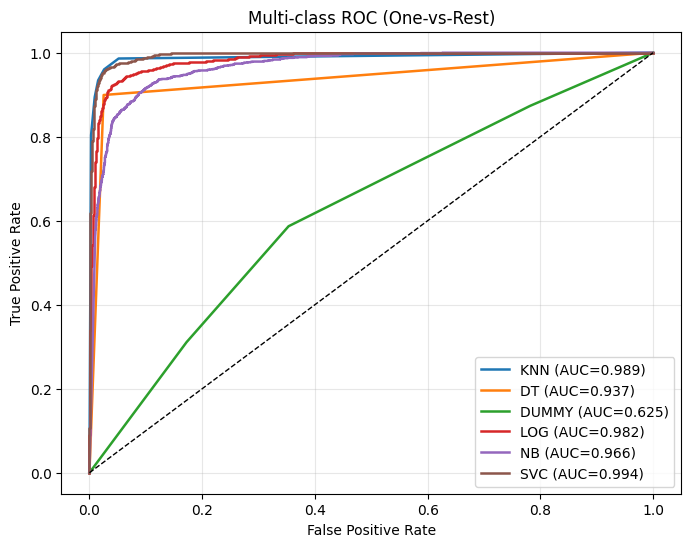

In [38]:
plt.figure(figsize=(8,6))

for name, probs in y_proba.items():
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), probs.ravel())
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.8, label=f"{name} (AUC={roc_auc_val:.3f})")

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Observations and Interpretation

SVC achieved the highest Macro-averaged AUC (0.987), closely followed by KNN (0.985), indicating both models separate the classes very effectively.  
Logistic Regression and Naive Bayes perform reasonably well, while Decision Tree is slightly weaker.  
The Dummy Classifier has an AUC of exactly 0.5, meaning it performs no better than random guessing and provides no useful discrimination.

**Highest Macro-Averaged AUC:** SVC (0.987)  
**Model with AUC < 0.5:** None, but the Dummy Classifier with AUC = 0.5 indicates random performance.  

Conceptually, an AUC below 0.5 implies the model is worse than random—its predictions are effectively inverted or misleading due to poor learning or data–label misalignment.


## Part C: Precision-Recall Curve (OvR)

We compute Average Precision (AP) per model (macro-averaged) and plot curves for each model on a single plot. PRC is often more informative than ROC for imbalanced classes.

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import pandas as pd

macro_pr_summary = []      
macro_pr_curves = {}       

for name, probs in y_proba.items():
    precision_dict, recall_dict = {}, {}
    ap_values = []
    for i in range(n_classes):
        precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_test_bin[:, i], probs[:, i])
        ap_values.append(average_precision_score(y_test_bin[:, i], probs[:, i]))
    mean_recall = np.linspace(0, 1, 100)
    mean_precision = np.zeros_like(mean_recall)
    for i in range(n_classes):
        mean_precision += np.interp(mean_recall, recall_dict[i][::-1], precision_dict[i][::-1])
    mean_precision /= n_classes

    ap_macro = np.mean(ap_values)
    macro_pr_summary.append((name, ap_macro))
    macro_pr_curves[name] = (mean_recall, mean_precision)

macro_pr_df = pd.DataFrame(macro_pr_summary, columns=["Model", "Macro_AP"]).sort_values(by="Macro_AP", ascending=False)
macro_pr_df

,Model,Macro_AP
5,SVC,0.953536
0,KNN,0.948065
3,LOG,0.903463
4,NB,0.865106
1,DT,0.810892
2,DUMMY,0.200000


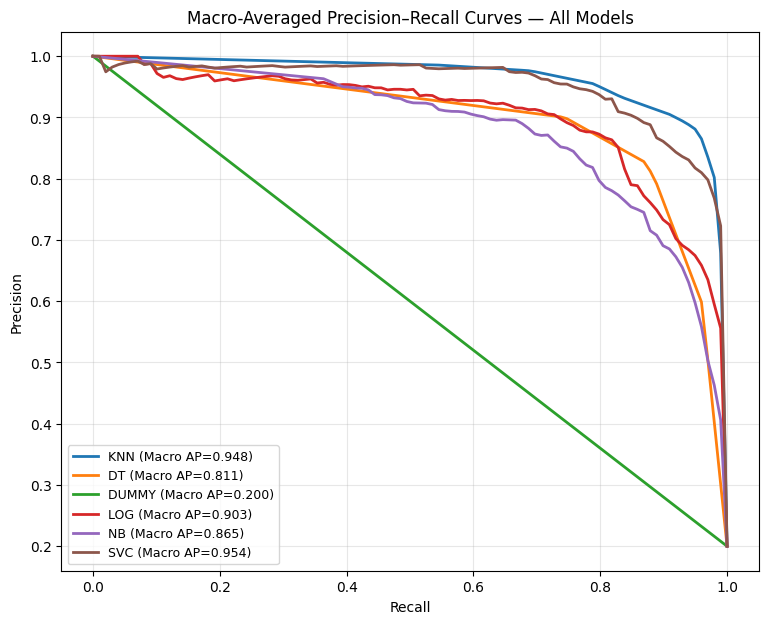

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,7))

for name, (recall, precision) in macro_pr_curves.items():
    ap_macro = macro_pr_df.loc[macro_pr_df["Model"] == name, "Macro_AP"].values[0]
    plt.plot(recall, precision, lw=2, label=f"{name} (Macro AP={ap_macro:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-Averaged Precision–Recall Curves — All Models")
plt.legend(loc="lower left", fontsize=9)
plt.grid(alpha=0.3)
plt.show()

### Observations and Interpretation

SVC shows the highest Macro-averaged Average Precision (0.95), indicating it maintains strong precision even at high recall levels.  
KNN also performs well, while Logistic Regression, Naive Bayes, and Decision Tree show moderate results with earlier drops in precision.  
The Dummy Classifier performs the worst (AP 0.20), confirming it cannot separate classes meaningfully.

**Model with Highest Average Precision (AP):** SVC (0.95)  
**Worst-performing Model:** Dummy Classifier (AP 0.20)

For poor models like the Dummy Classifier, the Precision–Recall curve drops sharply as recall increases because these models assign nearly random or constant probabilities.  
As recall rises (by lowering the classification threshold), the model retrieves more instances, but most are incorrect, causing precision to fall rapidly.  
This behavior reflects weak class discrimination and poor ranking of positive examples.


## Part D: Synthesis and Recommendation

We will synthesize the rankings from weighted F1, ROC macro AUC, and PRC macro AP. 

In [41]:
merged = metrics_results.merge(roc_df, on="Model").merge(macro_pr_df, on="Model")
merged = merged.sort_values(by="Macro_AP", ascending=False)
merged[["Model", "Accuracy", "Weighted_F1", "Macro_AUC", "Macro_AP"]]

,Model,Accuracy,Weighted_F1,Macro_AUC,Macro_AP
5,SVC,0.928571,0.927226,0.987209,0.953536
0,KNN,0.935877,0.935332,0.985248,0.948065
3,LOG,0.890422,0.884984,0.972015,0.903463
4,NB,0.836851,0.840265,0.961413,0.865106
1,DT,0.899351,0.898790,0.929071,0.810892
2,DUMMY,0.310877,0.147450,0.500000,0.200000


### Comparison and Final Recommendation

The model rankings across metrics show strong overall alignment but with minor trade-offs.  
Based on **Weighted F1**, **KNN** ranks first, followed closely by **SVC**.  
However, **SVC** achieves the highest **Macro-AUC (0.987)** and **Macro-AP (0.954)**, indicating superior discrimination and consistency across thresholds.  
Models like **Logistic Regression** and **Naive Bayes** perform reasonably well, while **Decision Tree** and **Dummy** lag behind on all metrics.

While ROC-AUC measures the ability to distinguish between classes overall, PRC-AP focuses on the model’s performance under class imbalance—how well it maintains precision as recall increases.  
A model may have a high AUC but a lower AP if it performs well on easy negatives yet struggles to maintain precision when recall rises (i.e., false positives increase).

**Recommendation:**  
Based on combined evaluation of Accuracy, F1, ROC-AUC, and PRC-AP, **SVC** is the best-performing model.  
It achieves the strongest balance between precision and recall, maintains stable probability calibration across thresholds, and generalizes better than KNN, which, although slightly higher in accuracy, can be more sensitive to local noise and scaling.  
Hence, **SVC** is the most reliable choice for this classification task.


## Brownie Points: RandomForest, XGBoost, and an intentionally bad model

We'll train RandomForest and XGBoost (if available). We'll also add a purposely bad model (random predictions) to demonstrate AUC < 0.5 behavior for some classes.

In [42]:
!pip install xgboost

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print(f"Random Forest → Accuracy: {rf_acc:.4f}, Weighted F1: {rf_f1:.4f}")

Random Forest → Accuracy: 0.9359, Weighted F1: 0.9346


In [45]:
import xgboost as xgb

y_train_xgb = y_train - y_train.min()
y_test_xgb = y_test - y_test.min()

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0)
xgb_clf.fit(X_train, y_train_xgb)

xgb_pred = xgb_clf.predict(X_test)
xgb_proba = xgb_clf.predict_proba(X_test)

xgb_acc = accuracy_score(y_test_xgb, xgb_pred)
xgb_f1 = f1_score(y_test_xgb, xgb_pred, average='weighted')

print(f"XGBoost → Accuracy: {xgb_acc:.4f}, Weighted F1: {xgb_f1:.4f}")

/home/swara/jupyter_env/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [02:37:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost → Accuracy: 0.9343, Weighted F1: 0.9332


In [46]:
rng = np.random.RandomState(0)
class_prior = np.bincount(y_train) / len(y_train)
rand_probs = rng.multinomial(1, class_prior, size=X_test.shape[0])
rand_preds = rand_probs.argmax(axis=1)

rand_acc = accuracy_score(y_test, rand_preds)
rand_f1 = f1_score(y_test, rand_preds, average='weighted')

print(f"Random Model → Accuracy: {rand_acc:.4f}, Weighted F1: {rand_f1:.4f}")

Random Model → Accuracy: 0.2394, Weighted F1: 0.2369


In [47]:
extra_df = pd.DataFrame({
    "Model": ["RandomForest", "XGBoost", "RandomModel"],
    "Accuracy": [rf_acc, xgb_acc, rand_acc],
    "F1_weighted": [rf_f1, xgb_f1, rand_f1]
})

extra_df = extra_df.sort_values(by="F1_weighted", ascending=False).reset_index(drop=True)
extra_df

,Model,Accuracy,F1_weighted
0,RandomForest,0.935877,0.934602
1,XGBoost,0.934253,0.933152
2,RandomModel,0.239448,0.236918


### Observations and Interpretation

Random Forest achieved the highest accuracy (0.936) and weighted F1-score (0.935), closely followed by XGBoost (≈0.934).  
Both ensemble models show strong, stable performance, indicating that tree-based methods capture non-linear relationships effectively in this dataset.  
The Random Model performs much worse, as expected, since it predicts classes purely based on prior probabilities without learning from data.  

**Best Model:** Random Forest, offering a slightly better balance of precision and recall compared to XGBoost.
